In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fredapi import Fred
import pyfolio as pf

/Users/alexlepoidevin/opt/anaconda3/lib/python3.9/site-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()
/Users/alexlepoidevin/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/alexlepoidevin/opt/anaconda3/lib/python3.9/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


### Hybrid Asset Allocation (HAA) Strategy

The Hybrid Asset Allocation (HAA) strategy combines both offensive and defensive asset allocation approaches based on the momentum of Treasury Inflation-Protected Securities (TIPS). The strategy dynamically shifts between offensive assets when TIPS momentum is positive and defensive assets when TIPS momentum is negative. The allocation within the offensive assets is based on the momentum of individual assets.

#### 1. Asset Classes

The asset universe consists of:
- Equities: $A_{\text{equities}} = \{\text{SPY}, \text{IWM}, \text{EFA}, \text{EEM}, \text{VNQ}\}$
- Commodities: $A_{\text{commodities}} = \{\text{DBC}\}$
- Bonds: $A_{\text{bonds}} = \{\text{IEF}, \text{TLT}, \text{TIP}, \text{BIL}\}$

#### 2. Calculation of Momentum

Define momentum as the average of 1-month, 3-month, 6-month, and 12-month percentage changes in prices:

$
\text{Momentum}_{i,t} = \frac{1}{4} \left( \frac{P_{i,t}}{P_{i,t-21}} - 1 + \frac{P_{i,t}}{P_{i,t-63}} - 1 + \frac{P_{i,t}}{P_{i,t-126}} - 1 + \frac{P_{i,t}}{P_{i,t-252}} - 1 \right)
$

where $P_{i,t}$ is the price of asset $i$ at time $t$.

#### 3. Allocation Strategy

- **Monthly Rebalancing:** Allocate at the end of each month.
- **Momentum Evaluation:** Evaluate the momentum of TIPS (TIP) to determine the asset allocation strategy.

##### Allocation Rules:

1. **TIPS Momentum Evaluation:**
   - Compute the momentum for TIPS.
   - If $\text{Momentum}_{\text{TIP},t} > 0$:
     - Select the offensive assets: $A_{\text{offensive}} = \{\text{SPY}, \text{IWM}, \text{EFA}, \text{EEM}, \text{VNQ}, \text{DBC}, \text{IEF}, \text{TLT}\}$
     - Compute the momentum for each offensive asset.
     - Select the top 4 offensive assets with the highest momentum.
     - Allocate 25% to each of the top 4 offensive assets if their momentum is positive.
     - If an offensive asset's momentum is not positive, allocate to the best defensive asset between IEF and BIL.
   - If $\text{Momentum}_{\text{TIP},t} \leq 0$:
     - Allocate 100% to the best defensive asset between IEF and BIL.


#### Summary

The Hybrid Asset Allocation (HAA) strategy dynamically shifts between offensive and defensive assets based on the momentum of TIPS. When TIPS momentum is positive, the strategy allocates to the top-performing offensive assets, and when TIPS momentum is negative, it allocates to defensive assets. This approach aims to optimize returns while mitigating risks through conditional asset selection and allocation rules.


[*********************100%%**********************]  10 of 10 completed


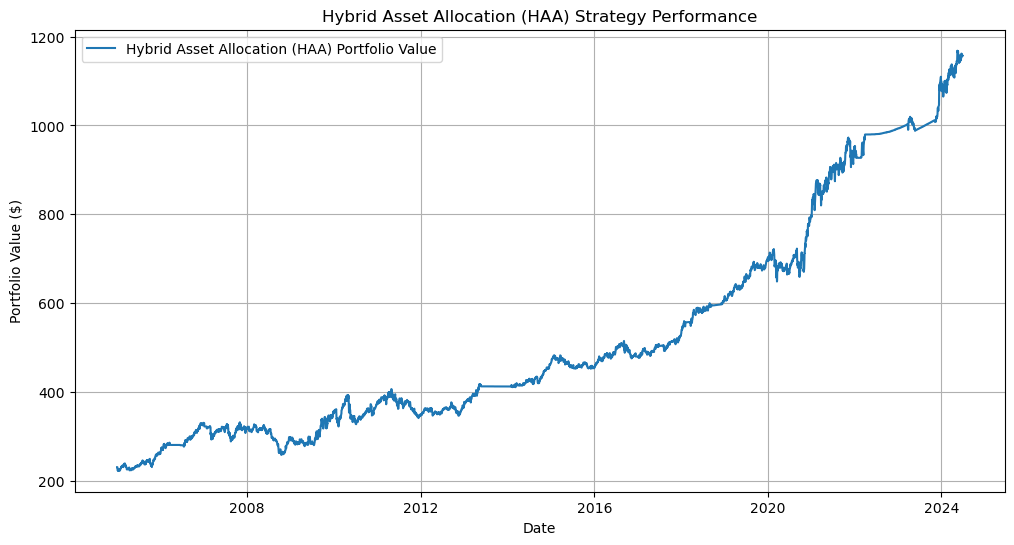

In [12]:
asset_classes = ['SPY', 'IWM', 'EFA', 'EEM', 'VNQ', 'DBC', 'IEF', 'TLT', 'TIP', 'BIL']
data = yf.download(asset_classes, start='2004-01-01')['Adj Close']

def calculate_momentum(data, window):
    return data.pct_change(window).mean(axis=1)

momentum_1m = data.pct_change(21)
momentum_3m = data.pct_change(63)
momentum_6m = data.pct_change(126)
momentum_12m = data.pct_change(252)
momentum = (momentum_1m + momentum_3m + momentum_6m + momentum_12m) / 4

portfolio = pd.DataFrame(index=data.index, columns=asset_classes, data=0.0)

for date in momentum.index[1:]:
    if date not in data.index:
        continue

    tips_momentum = momentum.at[date, 'TIP']
    
    if tips_momentum > 0:
        offensive_assets = ['SPY', 'IWM', 'EFA', 'EEM', 'VNQ', 'DBC', 'IEF', 'TLT']
        offensive_momentum = momentum.loc[date, offensive_assets]
        top_assets = offensive_momentum.nlargest(4).index
        
        for asset in top_assets:
            if momentum.at[date, asset] > 0:
                portfolio.loc[date, asset] = 0.25
            else:
                defensive_asset = 'IEF' if momentum.at[date, 'IEF'] > momentum.at[date, 'BIL'] else 'BIL'
                portfolio.loc[date, defensive_asset] += 0.25
    else:
        defensive_asset = 'IEF' if momentum.at[date, 'IEF'] > momentum.at[date, 'BIL'] else 'BIL'
        portfolio.loc[date, defensive_asset] = 1.0

portfolio = portfolio.resample('B').ffill().reindex(data.index, method='ffill').fillna(0)

portfolio_returns = (portfolio.shift(1) * data.pct_change()).sum(axis=1)

initial_investment = 230.3050994873047
portfolio_value = (1 + portfolio_returns).cumprod() * initial_investment

plt.figure(figsize=(12, 6))
plt.plot(portfolio_value[251:], label='Hybrid Asset Allocation (HAA) Portfolio Value')
plt.title('Hybrid Asset Allocation (HAA) Strategy Performance')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.show()


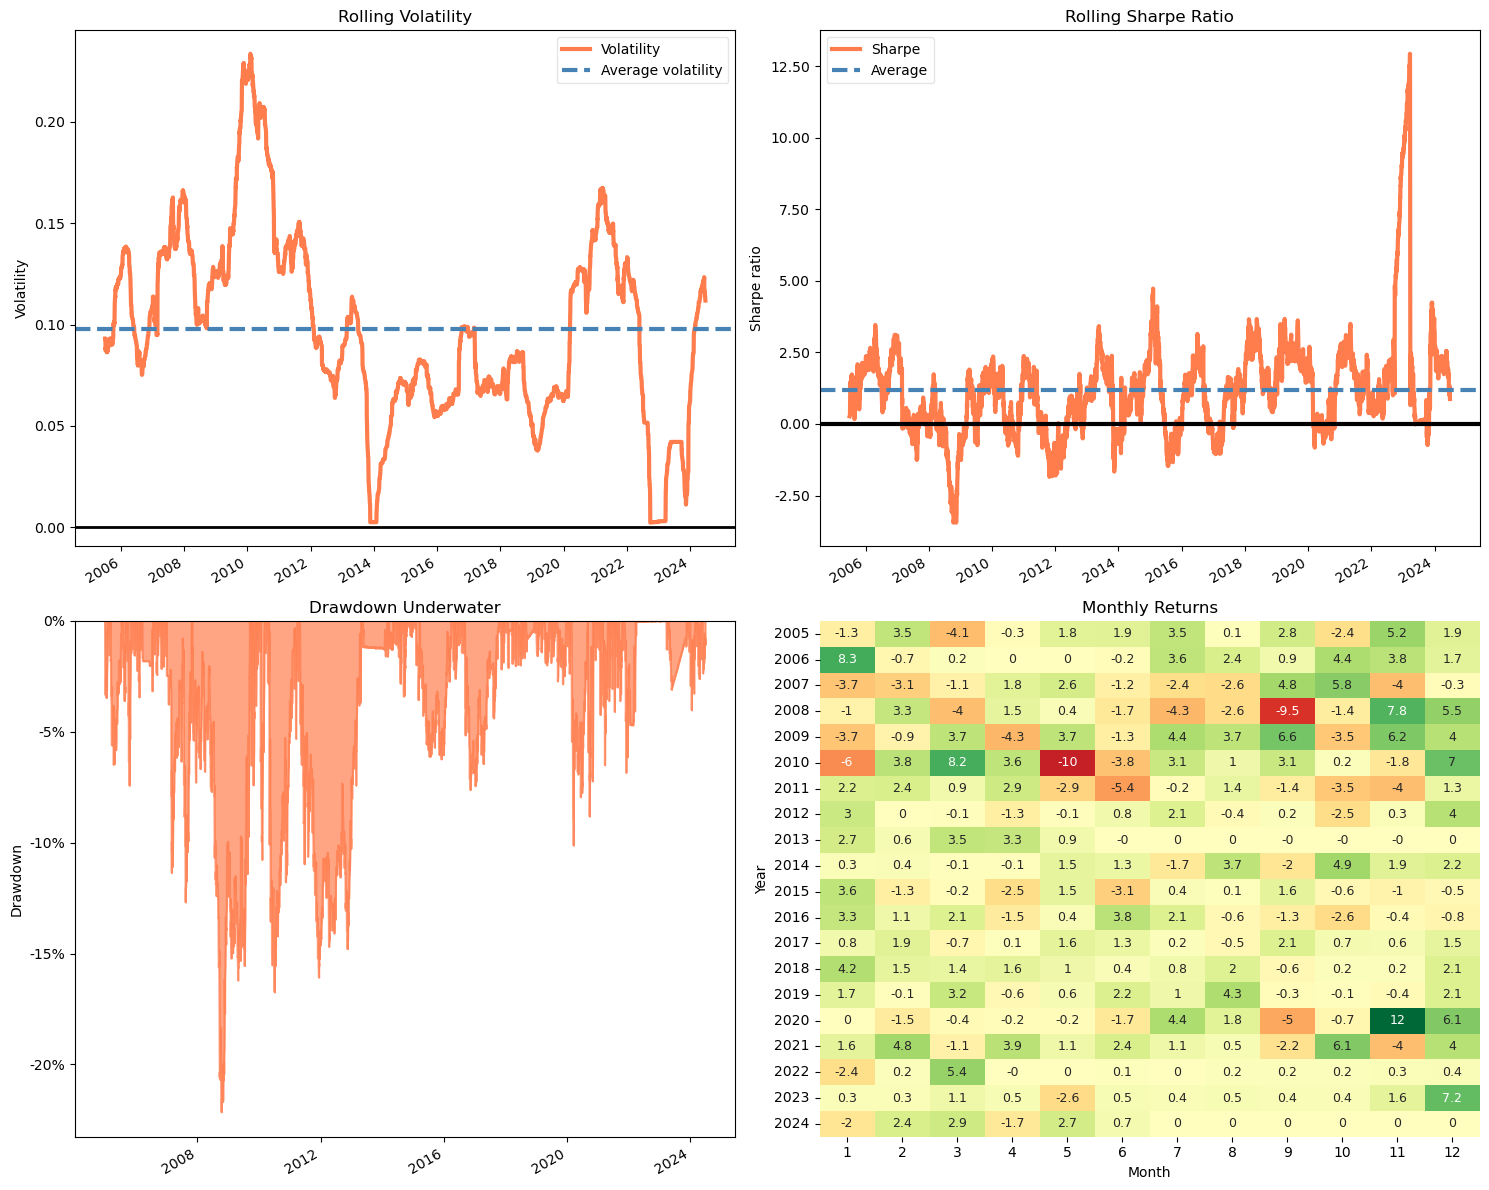

Annual return          0.086465
Cumulative returns     4.022035
Annual volatility      0.107985
Sharpe ratio           0.822197
Calmar ratio           0.390330
Stability              0.948331
Max drawdown          -0.221519
Omega ratio            1.173557
Sortino ratio          1.149220
Skew                  -0.508241
Kurtosis               4.595203
Tail ratio             1.038234
Daily value at risk   -0.013252
dtype: float64


/Users/alexlepoidevin/opt/anaconda3/lib/python3.9/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


In [13]:
strategy_returns = portfolio_value[251:].pct_change().dropna()
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

plt.sca(axs[0, 0])
pf.plot_rolling_volatility(strategy_returns, ax=axs[0, 0])
axs[0, 0].set_title('Rolling Volatility')

plt.sca(axs[0, 1])
pf.plot_rolling_sharpe(strategy_returns, ax=axs[0, 1])
axs[0, 1].set_title('Rolling Sharpe Ratio')

plt.sca(axs[1, 0])
pf.plot_drawdown_underwater(strategy_returns, ax=axs[1, 0])
axs[1, 0].set_title('Drawdown Underwater')

plt.sca(axs[1, 1])
pf.plot_monthly_returns_heatmap(strategy_returns)
axs[1, 1].set_title('Monthly Returns')

plt.tight_layout()
plt.show()


perf_stats = pf.timeseries.perf_stats(strategy_returns)
print(perf_stats)

<AxesSubplot:title={'center':'Annual returns'}, xlabel='Returns', ylabel='Year'>

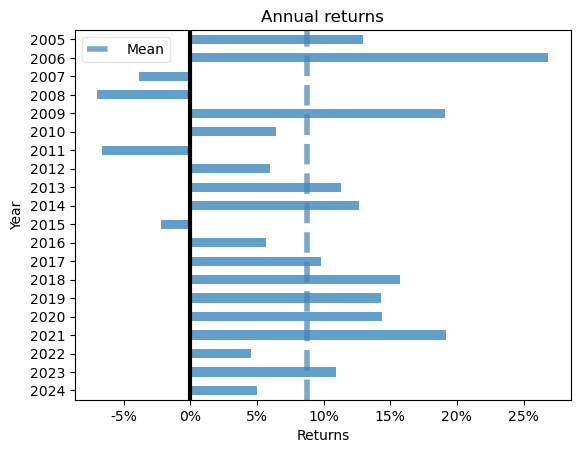

In [14]:
pf.plot_annual_returns(strategy_returns)

In [13]:
data["SPY"][712]

230.3050994873047